In [1]:
import os
import pandas as pd
import numpy as np
import gower
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import Image
from IPython.core.display import HTML 

import matplotlib.style
import matplotlib as mpl

mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.linewidth'] = 0.5
mpl.rcParams['figure.facecolor'] = 'white'

# A guide to clustering large datasets with mixed data-types

***Pre-note** If you are an early stage or aspiring data analyst, data scientist, or just love working with numbers clustering is a fantastic topic to start with. In fact I actively steer early career and junior data scientist toward this topic early on in their training and continued professional development cycle - sorry guys but its for your own good.*

*Learning how to apply and perform accurate clustering analysis takes you though many of the core principles of data analysis, mathematics, machine learning, and computational science. From learning about data types and geometry, confusion matrix, to applying iterative aglorithms and efficient computation on big data. These foundational concepts crop up in most other areas of data science and machine learning. For instance, cluster distance matrices underpin and, mathematically, are near identical to graph data structures used in deep learning graph neural networks at the cutting edge of artificial intelligence research. So if you are just starting out then dont be put of and read on regardless of your level. We all have to start somewhere and this is a very good place!*

# 1. Introduction

Cluster analysis is the task of grouping objects within a population in such a way that objects in the same group or cluster are more similar to one another than to those in other clusters. Clustering is a form of unsupervised learning as the number, size and distribution of clusters is unknown a priori.
Clustering can be applied to a variety of different problems and domains including: customer segmentation for retail sales and marketing, identifying higher or lower risk groups within [insurance portfolios](https://www.casact.org/pubs/dpp/dpp08/08dpp170.pdf), to finding [storm systems on Jupyter](https://astronomycommunity.nature.com/users/253561-ingo-waldmann/posts/48323-deep-learning-saturn), and even identifying [galaxies far far away](https://arxiv.org/abs/1404.3097).

Many real world datasets include combinations of numerical, ordinal (e.g. small, medium, large), and nominal (e.g. France, China, India) data features. However, many popular clustering algorithms and tutorials such as K-means are suitable for numerical data types only. This article is written on the assumption that these methods are familiar - but otherwise Sklearn provides an excellent review of these methods [here](https://scikit-learn.org/stable/modules/clustering.html#clustering) for a quick refresher. 

This article seeks to provide a review of methods and a practical application for clustering a dataset with mixed datatypes. You can find all of my code on [Github here](https://github.com/bpostance/training.data_science/blob/master/ML/2.3_Clustering/10-Clustering-Mixed-Data.ipynb)


## 1.1 Aim:
To evaluate methods to cluster datasets containing a variety of dataype's.

## 1.2 Objectives:
1. To research and review clustering techniques for mixed datatype datasets. 
1. To research and review feature encoding and engineering strategies. 
1. To apply and review clustering methods on a test dataset.

##  1.3 Case Study: auto-insurance claims
The California auto-insurance claims [dataset](https://www.kaggle.com/xiaomengsun/car-insurance-claim-data) contains 8631 observations with two dependent predictor variables Claim Occured and Claim Amount, and 23 independent predictor variables. The [data dictionary](https://rpubs.com/data_feelings/msda_data621_hw4) describe each variable including:
- Bluebook = car re-sale value. 
- MVR_PTS = [MotorVehicleRecordPoints (MVR) ](https://www.wnins.com/losscontrolbulletins/MVREvaluation.pdf) details an individual’s past driving history indicating violations and accidents over a specified period
- TIF = Time In Force / customer lifetime
- YOJ = years in job
- CLM_FRQ = # of claims in past 5 years
- OLDCLAIM = sum $ of claims in past 5 years


    - https://community.alteryx.com/t5/Alteryx-Designer-Discussions/Insurance-Datasets/td-p/440035
    - https://rpubs.com/data_feelings/msda_data621_hw4
    - https://rdrr.io/cran/HDtweedie/man/auto.html
    - https://cran.r-project.org/web/packages/insuranceData/insuranceData.pdf


In [2]:
# load data
DATA_PATH = os.path.join(os.getcwd(),'../_data')
raw = pd.read_csv(os.path.join(DATA_PATH,'car_insurance_claim.csv'),low_memory=False,)

# convert numerical-object to numericals
for col in ['INCOME','HOME_VAL','BLUEBOOK','OLDCLAIM', 'CLM_AMT',]:
    raw[col] = raw[col].replace('[^.0-9]', '', regex=True,).astype(float).fillna(0.0)

# clean textual classes
for col in raw.select_dtypes(include='object').columns:
        raw[col] = raw[col].str.upper().replace('Z_','',regex=True).replace('[^A-Z]','',regex=True)
        
data_types = {f:t for f,t in zip(raw.columns,raw.dtypes)}

raw[:5]

,ID,KIDSDRIV,BIRTH,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,...,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CLM_AMT,CAR_AGE,CLAIM_FLAG,URBANICITY
0,63581743,0,MAR,60.0,0,11.0,67349.0,NO,0.0,NO,...,MINIVAN,YES,4461.0,2,NO,3,0.0,18.0,0,HIGHLYURBANURBAN
1,132761049,0,JAN,43.0,0,11.0,91449.0,NO,257252.0,NO,...,MINIVAN,YES,0.0,0,NO,0,0.0,1.0,0,HIGHLYURBANURBAN
2,921317019,0,NOV,48.0,0,11.0,52881.0,NO,0.0,NO,...,VAN,YES,0.0,0,NO,2,0.0,10.0,0,HIGHLYURBANURBAN
3,727598473,0,MAR,35.0,1,10.0,16039.0,NO,124191.0,YES,...,SUV,NO,38690.0,2,NO,3,0.0,10.0,0,HIGHLYURBANURBAN
4,450221861,0,JUN,51.0,0,14.0,0.0,NO,306251.0,YES,...,MINIVAN,YES,0.0,0,NO,0,0.0,6.0,0,HIGHLYURBANURBAN


# 3. Method

## 3.1 Data pre-processing
Apply processing to correct and handle erroneous values, and rename fields and values to make the data easier to work with. Including:
 - remove or fill null values
 - drop irrelevant columns
 - shorten categorical value names

In [3]:
# copy df
df = raw.copy()

# drop ID and Birth
df.drop(labels=['ID','BIRTH'],axis=1,inplace=True)

# remove all nan values
df['OCCUPATION'].fillna('OTHER',inplace=True)
for col in ['AGE','YOJ','CAR_AGE']:
    df[col].fillna(df[col].mean(),inplace=True)
if df.isnull().sum().sum() == 0: print('No NaNs')
    
data_meta = pd.DataFrame(df.nunique(),columns=['num'],index=None).sort_values('num').reset_index()
data_meta.columns = ['name','num']
data_meta['type'] = 'numerical'

# exclude known numericals
data_meta.loc[(data_meta['num']<=15) & (~data_meta['name'].isin(['MVR_PTS','CLM_FREQ','CLAIM_FLAG'])),'type']='categorical'
data_meta.loc[data_meta['name'].isin(['CLM_FREQ','CLAIM_FLAG']),'type']='claim'

categorical_features = list(data_meta.loc[data_meta['type']=='categorical','name'])
numerical_features = list(data_meta.loc[data_meta['type']=='numerical','name'])

# shorten names
df['URBANICITY'] = df['URBANICITY'].map({'HIGHLYURBANURBAN':'URBAN',
                                           'HIGHLYRURALRURAL':'RURAL'})
df['EDUCATION'] = df['EDUCATION'].map({'HIGHSCHOOL':'HSCL',
                                         'BACHELORS':'BSC',
                                         'MASTERS':'MSC',
                                         'PHD':'PHD'})
df['CAR_TYPE'] = df['CAR_TYPE'].map({'MINIVAN':'MVAN', 
                                       'VAN':'VAN', 
                                       'SUV':'SUV',
                                       'SPORTSCAR':'SPRT',
                                       'PANELTRUCK':'PTRK', 
                                       'PICKUP':'PKUP'})

No NaNs


## 3.2 Exploratory Data Analysis

In [4]:
# # Mosaic Plots
# # https://rpubs.com/data_feelings/msda_data621_hw4
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from statsmodels.graphics.mosaicplot import mosaic

# props = {}
# for car in df['CAR_TYPE'].unique():
#     for i,color in zip([0,1],['grey','red']):
#         props[(str(i),car)] = {'color':color}
# props

# m = mosaic(df, ['CAR_TYPE','CLAIM_FLAG',], title='DataFrame as Source',properties=props)
# plt.show()

***Categorical feature histograms***

Shown below are the histogram of each categorical feature. This illustrates both the number and frequency of each category in the dataset.

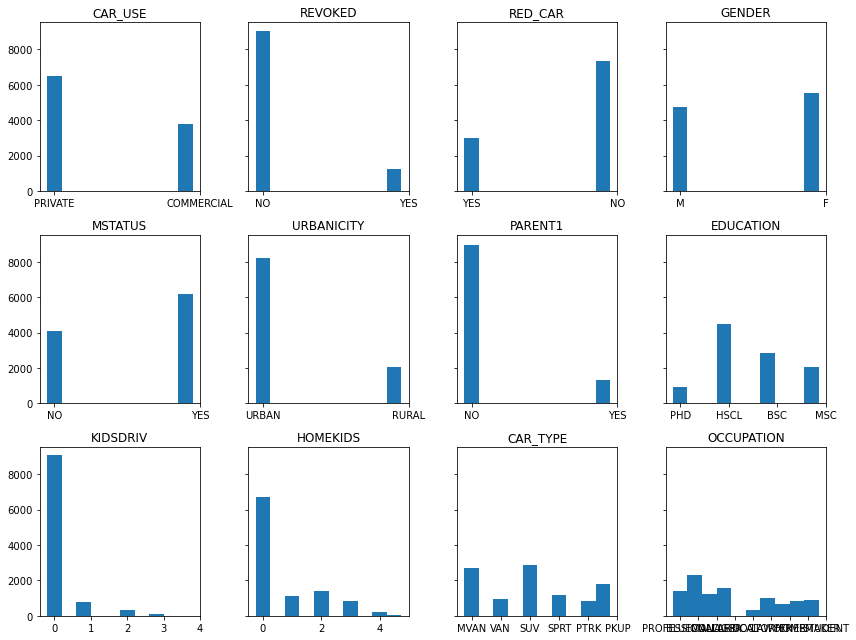

In [5]:
fig,axs = plt.subplots(3,4,figsize=(12,9),sharey=True)

for ax,feat in zip(axs.flatten(),categorical_features):
    ax.hist(df[feat],align='left')
    ax.set_title(feat)
plt.tight_layout()

***How are claims distributed amongst the categorical features?***

As above, the bar plots again illustrate each categorical feature and value, but now also show how the proportion of claims is distributed to each categorical value. For example, Commericial CAR_USE has a relatively higher proportion of claims than Private car use.

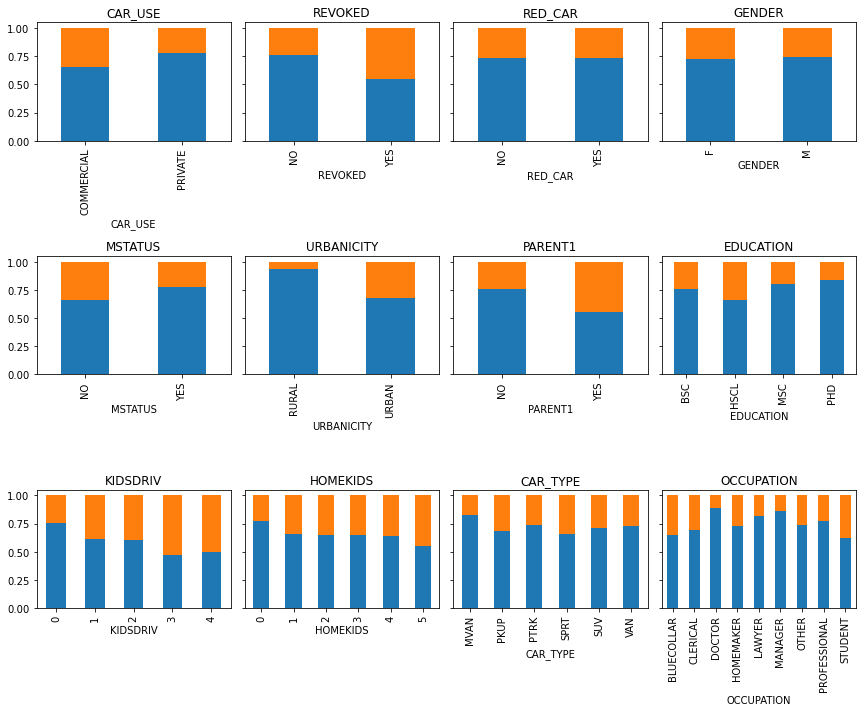

In [6]:
fig,axs = plt.subplots(3,4,figsize=(12,10),sharey=True)

for ax,feat in zip(axs.flatten(),categorical_features):
    ((pd.crosstab(df['CLAIM_FLAG'],df[feat])) / (pd.crosstab(df['CLAIM_FLAG'],df[feat]).sum())).T.plot.bar(stacked=True,ax=ax,legend=False,title=None)
    ax.set_title(feat)
plt.tight_layout()

## 3.3 Clustering

Recall that each clustering algorithm is an attempt to create natural groupings of the data. At a high-level, clustering algorithms acheive this using a measure of similarity or distance between each pair of data points, between groups and partitions of points, or between points and groups to a representative central point (i.e. centroid). So while the actual algorithm impementations to achive this vary, in essence they are based on this simple principle of distance.This is illustrated quite nicely in illustration below that shows a data set with 3 clusters, and iterative cluster partitioning a-f by updating the centroid points (Chen 2018). Here the clusters are formed by measuring the distance between each data point (solid fill) and a representative centoid point (hollow fill). 

<img src="https://www.researchgate.net/profile/Yu-Zhong-Chen/publication/324073652/figure/fig2/AS:611048927277056@1522696825062/A-schematic-illustration-of-the-K-means-algorithm-for-two-dimensional-data-clustering.png" width=650 height=650 />

Because clustering algortithms utilise this concept of distance both it is crucial to consider both:
- Distance Meaasures. The distance or "similarity" measure used.
- Feature Engineering. The nature of our data and the way the data is presented the clustering algorithm.

### 3.3.1 Distance Measures

Below are some of the common distance measures used for clustering. Computational efficiency is important here as each data feature introduces an additional dimension.For clustering, by definition, we often have a multiple features to make sense of and therefore the efficiency of the calculation in high dimensional space is crucial. 

***[Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance#Higher_dimensions)*** is the absolute numerical difference of their location in euclidean space. Distances can be 0 or take on any positive real number. It is given by the root sum-of-squares of differences between each pair (p,q) of points. And we can see that for high dimensions we simply add the distance. 

$$d_n(p,q) = \sqrt{(p_1-q_1)^2+(p_2-q_2)^2...+(p_n-q_n)^2}$$

***[Manhattan distance](https://en.wikipedia.org/wiki/Taxicab_geometry)*** is again the sum of the absolute numerical difference between two points in space, but using cartesian cooridantes. Whilst euclidean distance is the straight line "as the crow flies" with pythagorus theorem, Manhattan takes distance as the sum of the line vectors (p,q).

$$d_n(p,q)  = \sum_{i=1}^{n} |{(p_n-q_n)}|$$

This image illustrates examples for: a) euclidean space distance, b) Manhattan distance in cartesian cooridate space, and c) both with the green line showing a euclidean path, while the blue, red, and yellow lines take a cartesian path with Manhattan distance. This illustrates how clustering results may be influenced by distance measures applied and depending on wether the data features are real and numeric or discrete ordinal and categorical values. In addition, perhaps this also illustrates to you how and why geometry and distance are important in other domains such as shortest path problems. 
<img src="spaces.png" width=750 height=450 />

There are many distance metrics (e.g. see [these slides](http://halweb.uc3m.es/esp/Personal/personas/jmmarin/esp/MetQ/Talk6.pdf)). Minkowski distance for example, is a generalization of both the Euclidean distance and the Manhattan distance. Scipy has a covenient [pair distance](https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.spatial.distance.pdist.html) ```pdist()``` function that applies many of the most common measures. 

>**Example**:<br>
    ```
from scipy.spatial.distance import pdist
    pdist(df,metric='minkowski')
    ```

There are also hybrid distance measures. In our case study, and topic of this article, the data contains a mixture of features with different data types and this requires such a measure.

***[Gower (1971) distance](https://www.jstor.org/stable/2528823?seq)*** is a hybrid measure that handles both continuous and categorical data. 
- If the data feature are continuous or ordinal, the Manhattan or a ranked ordinal Manhattan is applied respectively. 
- If the data feature are categorical, then a [DICE](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient#Formula) coefficient is applied. DICE is explained [here](https://stats.stackexchange.com/a/55802/100439). However, If you are familiar with Jaccard coefficient and or binary classification (e.g. True Positives TP and False Posititves FP etc) and confusion matrices then DICE is going to be familiar as

$$DICE = \frac{2|X \cap Y|}{|X|+|Y|} = \frac{2TP}{2TP+FP+FN}$$

The Gower distance of a pair of points $G(p,q)$ then is:

$$G_n(p,q) = \frac{\sum_{i=1}^{n}W_{pqk}S_{pqk}}{\sum_{i=1}^{n}W_{pqk}}$$

where $S_{pqk}$ is either the Manhattan or DICE value for feature $k$, and $W_{pqk}$ is either 1 or 0 if $k$ feature is valid. Its the sum of feature scores divided by the sum of feature weights. 

### 3.3.2 Feature Engineering

With this improved understanding of the clustering distance measures it is now clear that the scale of our data features is equally important. For example, imagine we were clustering cars by their performance and weight characteristics. 
- Car A does 0-60 mph in 3.5 seconds and has mass 3000 KG
- Car B does 0-60 mph in 5.5 seconds and has mass 5000 KG

The feature distances between Car A and B are 2.0 seconds and 2000 KG. Thus our 2000 unit distance for mass is orders of magnitude higher than 2.0 seconds for 0-60 mph. Clustering data in this form would yield results bias toward high range features (see more examples in these StackOverflow answers [1](https://datascience.stackexchange.com/questions/22795/do-clustering-algorithms-need-feature-scaling-in-the-pre-processing-stage/22915),[2](https://stats.stackexchange.com/a/7182/100439),[3](https://stats.stackexchange.com/questions/385775/normalizing-vs-scaling-before-pca)). When using any algorithm that computes distance or assumes normally distributed data, scale your features [4](https://medium.com/greyatom/why-how-and-when-to-scale-your-features-4b30ab09db5e).

For datasets with mixed data-types consider you have scaled all features to between 0-1. This will ensure distance measures are applied uniformly to each feature. The numerical features will have distances with min-max 0-1 and real numbers between e.g. 0.1,0.2,0.5,...0.99. Whereas the distances for categorical feautures be values of either 0 or 1. As for mass KG in the car example above, this could still lead to a bias in the formation of clusters toward categorical feature groups as their distances are always either the min-max value of 0 or 1.

Selecting the appropriate transformations and scaling to apply is part science and part art. There are often several strategies that may suit and must be applied and evalauted in relation to the context of challenge at hand, the data and its domain. Crucially, whatever strategy is adopted,  **all features** in the final dataset that is used for clustering data must be on the same scale for each eature to be treated equally by the distance metrics. 


***Different data-types and how to handle them***

Here are two excellent articles and figures that delve deeper on (left) [data-types](https://towardsdatascience.com/data-types-in-statistics-347e152e8bee) and (right) [encoding techniques](https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02). 

<p align="middle">
  <img src="https://miro.medium.com/max/700/1*dvvxoZTdewLFs3RyZTJreA.png" width="30%"/>
  <img src="https://innovation.alteryx.com/content/images/2019/08/categorical-encoding-01-01.png" width="30%" />
</p>

In summary these are:

***Numerical features:*** continous and interval features such as mass, age, speed, luminosity, friction. 
 - Use ratios and percentages.
 - normalisation (i.e. normalise values to be on scale of 0-1)
 - standardisation (i.e. how many standard deviations the value is from the sample mean)
 - transformation (i.e. log transformation).


***Nominal Categorical features:*** Unordered nominal or binary symmetric values where outcomes are of equal importance (e.g. Male or Female).
 - One-hot and dummy encoding (i.e. create binary indicator of each category).
 - If handling a feature with high cardinality >15, try to reduce dimensionality by feature engineering or apply binary or hash encoding. 
 
 
***Ordinal Categorical features:*** Ordered ordinal or binary asymmetric values, where outcomes are not of equal importance.
>**Example**: consider the ordinal categorical feautre for olmypic medals encoded as Bronze=1, Silver=2, Gold=3. Here bronze (= 1 * 1), silver (= 2 * bronze), gold (= 3 * bronze). The difference between Gold-Bronze (= 3-1 = 2) is greater than between Gold and Silver (= 3-2 = 1) worse. Clearly this is ordinal as each category has a rank and relative scale comapred to each other category.
 - Label encoding with 0-1 normalisation if values are of equal-importance and on increasing scale. 
  - Rank values with 0-1 normalisation, again if values are on equal-importance increasing scale.
 - If there is a binary target variable in the dataset (e.g. event occurence, medical diagnosis, iris type), one can also assign frequencies, odd ratios, or weights-of-evidence to each ordinal class.

By far ordinal data is the most challenging to handle. There are many arguments between mathmatical purists, statisticians and other data practitioners on wether to treat ordinal data as qualitatively or quantitatively ([see here](https://creativemaths.net/blog/ordinal/)).


>**NOTE**: Distance measures and encoding is perhaps THE hardest part to clustering data. In this authors opinion, especially for categorical and ordinal features, data should be treated with caution and practitioners should trial and evaluate different feature engineering and encdoing strategies based on their understanding of the data and its domain. My other recommendation is to trial and test different strategies first with smaller datasets and those where you have a reasonable understanding of what the clusters SHOULD be (Iris, Titanic). Valid your approach on these data, and then apply to you own data and build up the complexity from there deciding where to put more focus on tuning the encoding process. Here are some more useful links: <br>
> - [Binary symmetric and assymetric variables](https://www.quora.com/What-are-binary-symmetric-and-asymmetric-attributes)
> - [datatype conversions in clustering](https://paginas.fe.up.pt/~ec/files_0506/slides/05_Clustering.pdf)
> - [Normalization vs Standardization — Quantitative analysis](https://towardsdatascience.com/normalization-vs-standardization-quantitative-analysis-a91e8a79cebf)
> - [Normalization vs Standardization](https://stats.stackexchange.com/a/10291/100439)


### 3.3.3 Clustering Methods
There are  also considertions for the clustering algorithim that is applied. These will be introduced and discussed on application to the case study dataset in the results section.

# 4. Results

## 4.1 Feature Engineering

***Scaling numerical features***

Below, both Standard and MinMax scaling is applied to show how the data is transformed. The MinMax scaled data is used going forward. 

In [7]:
from sklearn.preprocessing import scale,RobustScaler,StandardScaler, MinMaxScaler

In [8]:
df[numerical_features][:2]

,MVR_PTS,YOJ,TIF,CAR_AGE,AGE,TRAVTIME,CLM_AMT,BLUEBOOK,OLDCLAIM,HOME_VAL,INCOME
0,3,11.0,11,18.0,60.0,14,0.0,14230.0,4461.0,0.0,67349.0
1,0,11.0,1,1.0,43.0,22,0.0,14940.0,0.0,257252.0,91449.0


In [9]:
# Standard Scaled "mean normalisation"
scaler = StandardScaler()
scaler.fit(df[numerical_features])
print("Feature Means:\t",[f"{x:.2}" for x in scaler.mean_])
numerical_data = scaler.transform(df[numerical_features])
numerical_data = pd.DataFrame(numerical_data,index=df.index,columns=numerical_features)
numerical_data[:2]

Feature Means:	 ['1.7', '1e+01', '5.3', '8.3', '4.5e+01', '3.3e+01', '1.5e+03', '1.6e+04', '4e+03', '1.5e+05', '5.8e+04']


,MVR_PTS,YOJ,TIF,CAR_AGE,AGE,TRAVTIME,CLM_AMT,BLUEBOOK,OLDCLAIM,HOME_VAL,INCOME
0,0.597453,0.131552,1.379567,1.753103,1.762458,-1.223551,-0.319843,-0.169656,0.048899,-1.118502,0.190439
1,-0.792137,0.131552,-1.053171,-1.318759,-0.213574,-0.719421,-0.319843,-0.085417,-0.461938,0.853671,0.690195


In [10]:
# MinMax scaled
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(df[numerical_features])
numerical_data = scaler.transform(df[numerical_features])
numerical_data = pd.DataFrame(numerical_data,index=df.index,columns=numerical_features)
numerical_data[:2]

,MVR_PTS,YOJ,TIF,CAR_AGE,AGE,TRAVTIME,CLM_AMT,BLUEBOOK,OLDCLAIM,HOME_VAL,INCOME
0,0.230769,0.478261,0.416667,0.677419,0.676923,0.065693,0.0,0.186547,0.078212,0.000000,0.183497
1,0.000000,0.478261,0.000000,0.129032,0.415385,0.124088,0.0,0.196952,0.000000,0.290588,0.249159


***Sacling categorical features: ordinal & nominal***

Examining our EDA above plots in section 3.2, we may want to combine some classes where there are low target frequencies and or high cardinality. These are:

 - KIDSDRIV: collapse >= 2 to single category
 - HOMEKIDS: collapse >= 4 to single category

In [11]:
# you can use map
df['KIDSDRIV'] = df['KIDSDRIV'].map({0:0,1:1,2:2,3:2,4:2})
# or pd.cut()
df['HOMEKIDS']= pd.cut(df['HOMEKIDS'],
                       bins=[0,1,2,3,4,10],
                       labels=[0,1,2,3,4],
                       include_lowest=True,
                       right=True).astype(float)

Remember, nominal features are categoricals with values that have no order. Here, we could argue that EDUCATION and OCCUPATION are either nominal (i.e. unordered) or ordinal (i.e. ordered). This could be quite a debate....but there is a good argument to treat EDUCATION as ordinal and OCCUPATION as a categorical nominal. KIDSDRIV and HOMEKIDS can also be considered ordered and increasing in scale, however the adjustments we just made to the upper values are not symtetric in scale. This could be OK though given that there is very little data for the upper categories. 

Let's keep them as they are here. I will also apply MinMax scaling with range 0-1.

In [12]:
# create some lists
ordinal_features = ['EDUCATION','KIDSDRIV','HOMEKIDS']
print("Ordinals:\n",ordinal_features)

# apply order to education
df['EDUCATION'] = df['EDUCATION'].map({'HSCL':0, 'BSC':1, 'MSC':2,'PHD':3})
ordinal_data = df[ordinal_features]

# MinMax scaled
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(df[ordinal_features])
ordinal_data = scaler.transform(df[ordinal_features])
ordinal_data= pd.DataFrame(ordinal_data,index=df.index,columns=ordinal_features)
ordinal_data[:2]

Ordinals:
 ['EDUCATION', 'KIDSDRIV', 'HOMEKIDS']


,EDUCATION,KIDSDRIV,HOMEKIDS
0,1.0,0.0,0.0
1,0.0,0.0,0.0


For nominals that are binary features you can leave them as a single series indicator (e.g. Red Car Yes (1) or No (0)) or split them to two mutually exclusive one-hot-encoded series (e.g RedCarYes and RedCarNo). For some methods such as XGBoost the latter approach is preffered. 

Below I have written a for loop that keeps a single series for binary features and creates n-dimnesional feautres for nominal features with n+2 values.

No need to scale here as all the values are either 0 or 1. 

In [13]:
# For the nominals one-hot-encoding is applied
nominal_features = [c for c in categorical_features if c not in ordinal_features]
print("Nominals:\n",nominal_features)

nominal_data = list()
for i,x in df[nominal_features].nunique().iteritems():
    if x <= 2:
        nominal_data.append(pd.get_dummies(df[[i]],drop_first=True))
    elif x > 2:
        nominal_data.append(pd.get_dummies(df[[i]],drop_first=False))
        
nominal_data = pd.concat(nominal_data,axis=1)
nominal_data[:2]

Nominals:
 ['CAR_USE', 'REVOKED', 'RED_CAR', 'GENDER', 'MSTATUS', 'URBANICITY', 'PARENT1', 'CAR_TYPE', 'OCCUPATION']


,CAR_USE_PRIVATE,REVOKED_YES,RED_CAR_YES,GENDER_M,MSTATUS_YES,URBANICITY_URBAN,PARENT1_YES,CAR_TYPE_MVAN,CAR_TYPE_PKUP,CAR_TYPE_PTRK,...,CAR_TYPE_VAN,OCCUPATION_BLUECOLLAR,OCCUPATION_CLERICAL,OCCUPATION_DOCTOR,OCCUPATION_HOMEMAKER,OCCUPATION_LAWYER,OCCUPATION_MANAGER,OCCUPATION_OTHER,OCCUPATION_PROFESSIONAL,OCCUPATION_STUDENT
0,1,0,1,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,1,1,0,1,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0


***Final Datasets used for clustering***

I will create two copies of the data:
 1. using the above OHE transformations and feature scaling (0,1).
 2. applying the above transformations but without feature scaling. The reason for this one is because some distance and clustering packages handle the preparation for you - but its good to know how to do it yourself. 

In [14]:
# transformed and scaled dataset
Xy_scaled = pd.concat([numerical_data,nominal_data,ordinal_data],axis=1)
print(f'Data min:max {Xy_scaled.min().min(),Xy_scaled.max().max()}')

# original data
Xy_original = df[numerical_features+nominal_features+ordinal_features].copy()

Data min:max (0.0, 1.0)


## 4.2 Clustering methods for mixed datatypes

In this section several clustering algorithms and approaches are applied. However, first, some generic cluster evaluation techniques are introduced.

### Evaluation techniques: 
***Elbow plots, Silhouette Scores, and Silhouette Samples***

In [15]:
from sklearn.cluster import KMeans
from matplotlib import cm
from sklearn.manifold import TSNE
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

To illustrate the evaluation techniques we will generate some simple clusters using sklearn ```make_blobs```.

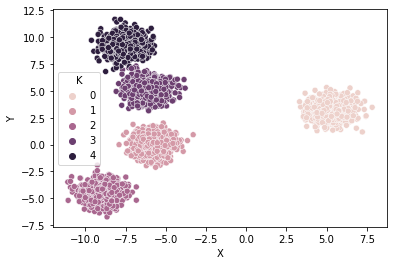

In [16]:
Xy_,clusters_ = make_blobs(n_samples=4000, centers=5, cluster_std=0.7)
df_ = pd.DataFrame(Xy_,columns=['X','Y'])
df_['K'] = clusters_
sns.scatterplot(x='X',y='Y',hue='K',data=df_);

To help evaluate and identify the optimal number of clusters $k$ in a single plot, one can apply the following methods: 

- The clustering metric Elbow technique. We can directly use the clustering measure to evaluate the cluster results. For kmeans, clusters are created by minimising Intertia (see 4.2.1 below). The so called ["elbow technique"](https://medium.com/@jyotiyadav99111/selecting-optimal-number-of-clusters-in-kmeans-algorithm-silhouette-score-c0d9ebb11308) plots intertia and the optimal number of clusters $k$ is selected as the point where intertia is inflected. The left plot below indicates that intertia stops changing substantially aroun $k=5$, the true number of clusters. 

- The [silhouette score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score) is a measure of cluster seperation and similarity. The score combines the the average intra-cluster difference and the nearest-cluster distance of each sample. With 1 being best "all cluster samples are similar" and -1 being worst "clusters are dissimila and overlapping". The sklearn ```silhouette_score()``` function can in-fact calculate any pairwise distance metric from sklearn or ```scipy.spatial.distance```. For KMeans, euclidean distance is the default score but we can also use Correlation, Manhattan, etc metrics. As for the Elbow approach, $k$ is selected that optimises the selected metric.

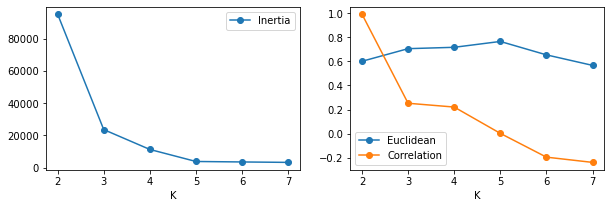

In [17]:
results = dict()
k_cand = [2,3,4,5,6,7] #

for k in k_cand:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(Xy_)
    score0 = kmeans.inertia_
    score1 = silhouette_score(Xy_,kmeans.labels_,metric='euclidean')
    score2 = silhouette_score(Xy_,kmeans.labels_,metric='correlation')
    results[k] = {'k':kmeans,'s0':score0,'s1':score1,'s2':score2}

fig,axs = plt.subplots(1,2,sharex=True,figsize=(10,3))
axs[0].plot([i for i in results.keys()],[i['s0'] for i in results.values()],'o-',label='Inertia')
axs[1].plot([i for i in results.keys()],[i['s1'] for i in results.values()],'o-',label='Euclidean')
axs[1].plot([i for i in results.keys()],[i['s2'] for i in results.values()],'o-',label='Correlation')
for ax in axs:
    ax.set_xticks(k_cand)
    ax.set_xlabel('K')
    ax.legend()

Selecting the optimal value for $k$ can also be aided by closer inspecting the samples and clusters themselves. Sklearn has a nice tutorial [here](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py). These include:

- [Silhouette Samples](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_samples.html#sklearn.metrics.silhouette_samples) show the per data point silhouette score wihtin a cluster (left). The coloured bars are the data points within eac cluster, where width is the data point silhouette score. The vertical dashed line is the average score per data point across all clusters. The cluster bard group height indicates the size of the cluster. Clusters and samples with "noisy" silhouette plots in terms of unequal widths and heights indicates poor clustering. 

- Cluster centroids (right). Accompanying the silhouette sample plots, the data clusters and centroids are shown explicitly.

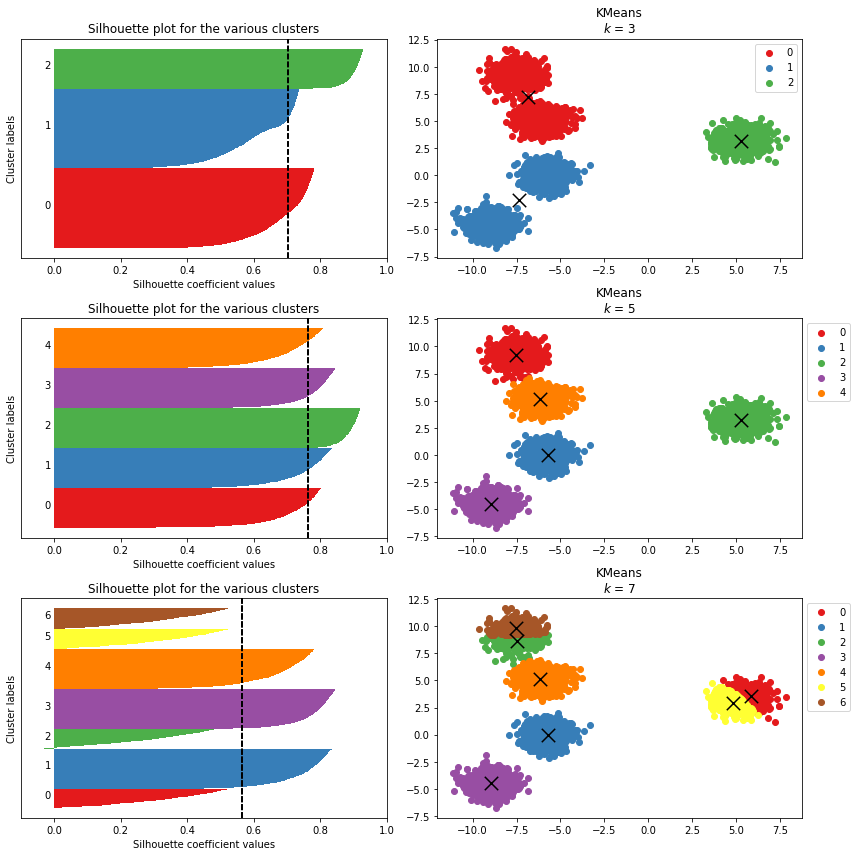

In [18]:
k_cand = [3,5,7]

fig,axs = plt.subplots(len(k_cand),2,figsize=(12,12))

for e,k in enumerate(k_cand):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(Xy_)
    
    cdict = {i:cm.Set1(i) for i in np.unique(kmeans.labels_)}
    
    ## silhouette samples
    silhouette_vals = silhouette_samples(Xy_,kmeans.labels_)
    y_lower = 0 
    y_upper = 0
    for i,cluster in enumerate(np.unique(kmeans.labels_)):
        cluster_silhouette_vals = silhouette_vals[kmeans.labels_==cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        axs[e,0].barh(range(y_lower,y_upper),
                      cluster_silhouette_vals,
                      height=1,
                      color=cdict[cluster])
        axs[e,0].text(-0.03,(y_lower+y_upper)/2,str(i))
        
        y_lower += len(cluster_silhouette_vals) # add for next iteration 
        avg_score = np.mean(silhouette_vals)
        axs[e,0].axvline(avg_score,linestyle ='--',color = 'black')
        
        axs[e,0].set_yticks([])
        axs[e,0].set_xlim([-0.1, 1])
        axs[e,0].set_xlabel('Silhouette coefficient values')
        axs[e,0].set_ylabel('Cluster labels')
        axs[e,0].set_title('Silhouette plot for the various clusters')
        
    ## plot data and cluster centroids
    results = pd.DataFrame(Xy_)
    results['k'] = kmeans.labels_
    for cluster in np.unique(kmeans.labels_): # plot data by cluster
        axs[e,1].scatter(x=results.where(results['k']==cluster)[0],
                         y=results.where(results['k']==cluster)[1],
                         color=cdict[cluster],
                         label=cluster)
    # plot centroids
    axs[e,1].scatter(x=kmeans.cluster_centers_[:,0],
                     y=kmeans.cluster_centers_[:,1],
                     marker='x',color='black',s=180)
    axs[e,1].legend(bbox_to_anchor=(1,1))
    axs[e,1].set_title(f"KMeans\n$k$ = {k}")
    plt.tight_layout()

For the scatter plots. If you have multiple features in your clustering data, or otherwise do not have the distance matrix, then first you must apply a decomposition technique such as PCA, MCA, or t-SNE to obtain a 2 or 3 dimensional vectors for plotting. 

>***NOTE*** use t-SNE with caution as this alters the scale and magnitude of the feature spaces and some methods, such as plotting centroids, will not work as shown below. See [here](https://stats.stackexchange.com/questions/271705/what-is-the-good-use-for-t-sne-apart-from-data-visualization) and [here](https://stats.stackexchange.com/questions/263539/clustering-on-the-output-of-t-sne) for explanations and guidance using t-SNE.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.005s...
[t-SNE] Computed neighbors for 4000 samples in 0.132s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 0.504213
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.919662
[t-SNE] KL divergence after 500 iterations: 1.553155


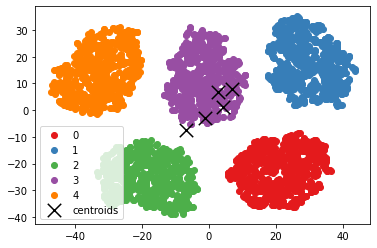

In [19]:
a,b = make_blobs(n_samples=4000,n_features=5, centers=5, cluster_std=0.7)
kmeans = KMeans(n_clusters=5, random_state=0).fit(a)

tsne_model = TSNE(n_components=2, verbose=1, random_state=0, n_iter=500)
tsne = tsne_model.fit_transform(a)
tsne = pd.DataFrame(tsne)
tsne['k'] = kmeans.labels_

for cluster in np.unique(kmeans.labels_): # plot data by cluster
    plt.scatter(x=tsne.where(tsne['k']==cluster)[0],
                y=tsne.where(tsne['k']==cluster)[1],
                color=cdict[cluster],
                label=cluster)

plt.scatter(kmeans.cluster_centers_[:,0],
            kmeans.cluster_centers_[:,1],
            marker='x',color='black',s=180,
            label='centroids')
plt.legend();

### 4.2.1 K-Means

The KMeans algorithm attempts to cluster data by creating groups that minimise the within-cluster sum-of-squared differences, aka inertia. Inertia measures the similarity of each pair of points as the Euclidean distance between them, smaller distances == higher similarity. The KMeans algorithm is computed in 3 steps:
1. $k_n$ initial random centroids are chosen. 
1. data points are assigned to their nearest $k_i$ centroid.
1. new centroids are created as the mean location of $k_i$ and its assigned points. Step 2 and 3 are repeated on the new cetroids until there is little to no change between iterations. 

KMeans works well on large datasets with numerical features, uniform cluster size, and where clusters are convex and isotropic "blobs". For a full description of KMeans and its limitations see [sklearn KMeans documentation](https://scikit-learn.org/stable/modules/clustering.html#k-means). 

For high-dimensional data (e.g. lots of features) and with mixed data-types, there is a high likelihood that the Intertia and Euclidean distances become insignificant due to the [curse of high dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality#Distance_functions). Simply put, in high-dimensional space and with independantly distributed features (i.e. no correlation) it is typical that the pairwise distances between any and all points becomes very small. This could well be a problem for our data set with categorical features. 

Applying KMeans to our scaled dataset shows there may be a high number of clusters. This may reflect some actual clusters within the data. But it may also be an artefact of having mixed numerical and categorical features and limitations of KMeans given high dimensionality of the data.

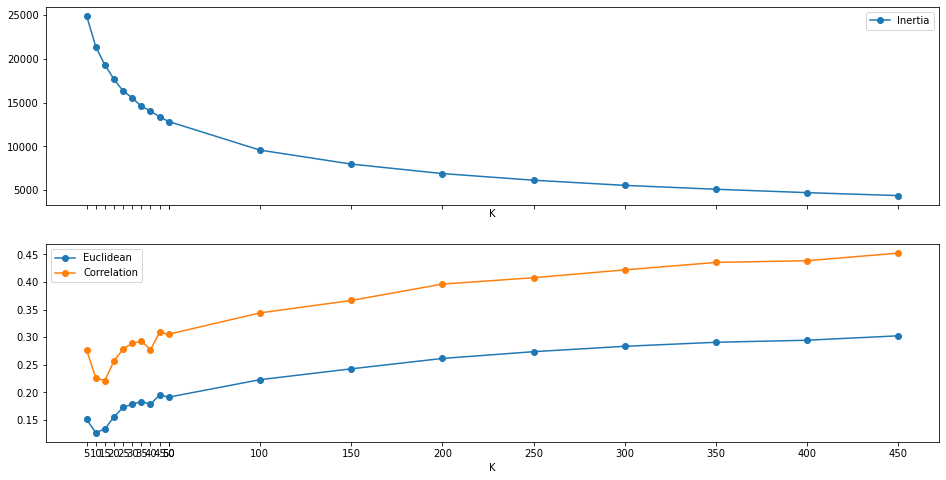

In [20]:
results = dict()
k_cand = list(np.arange(5,55,5))
k_cand.extend(list(np.arange(50,500,50)))

for k in k_cand:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(Xy_scaled)
    score0 = kmeans.inertia_
    score1 = silhouette_score(Xy_scaled,kmeans.labels_,metric='euclidean')
    score2 = silhouette_score(Xy_scaled,kmeans.labels_,metric='correlation')
    results[k] = {'k':kmeans,'s0':score0,'s1':score1,'s2':score2}

fig,axs = plt.subplots(2,1,sharex=True,figsize=(16,8))
axs[0].plot([i for i in results.keys()],[i['s0'] for i in results.values()],'o-',label='Inertia')
axs[1].plot([i for i in results.keys()],[i['s1'] for i in results.values()],'o-',label='Euclidean')
axs[1].plot([i for i in results.keys()],[i['s2'] for i in results.values()],'o-',label='Correlation')
for ax in axs:
    ax.set_xticks(k_cand)
    ax.set_xlabel('K')
    ax.legend()

As $k$ increases inertia and silhouette scoring is shown to improve. There are simply too many $k$ to make silhouette sampling and centroid plotting viable, however we can plot this using t-SNE to visually inspect what is happening. Albeit crudely. There seems to be a degree of good seperation in the t-SNE plot but also with some larger blobs of mixed colours.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10302 samples in 0.001s...
[t-SNE] Computed neighbors for 10302 samples in 2.468s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10302
[t-SNE] Computed conditional probabilities for sample 2000 / 10302
[t-SNE] Computed conditional probabilities for sample 3000 / 10302
[t-SNE] Computed conditional probabilities for sample 4000 / 10302
[t-SNE] Computed conditional probabilities for sample 5000 / 10302
[t-SNE] Computed conditional probabilities for sample 6000 / 10302
[t-SNE] Computed conditional probabilities for sample 7000 / 10302
[t-SNE] Computed conditional probabilities for sample 8000 / 10302
[t-SNE] Computed conditional probabilities for sample 9000 / 10302
[t-SNE] Computed conditional probabilities for sample 10000 / 10302
[t-SNE] Computed conditional probabilities for sample 10302 / 10302
[t-SNE] Mean sigma: 0.428354
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.685791
[t-SNE] KL 

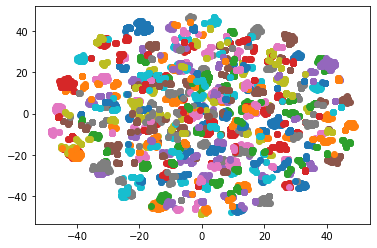

In [21]:
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, n_iter=500)
tsne = tsne_model.fit_transform(Xy_scaled)
tsne = pd.DataFrame(tsne)
tsne['k'] = results[400]['k'].labels_

for cluster in np.unique(kmeans.labels_): # plot data by cluster
    plt.scatter(x=tsne.where(tsne['k']==cluster)[0],
                y=tsne.where(tsne['k']==cluster)[1]
               )

Herein lies another problem of unsupervised learning - what are the correct clusters? There is no definitive answer in this case. You will have to apply a blend of domain knowledge and expertise with the clustering results and interpretation to derive the most meaningfull insights from the clusters. Here you can utilise other methods, diagnostic statistics, and visualisations, to interpret and assess your clusters. These might include:
- association tests: correlation, cramer's V, chi-square tests
- box plotting and distribution tests between clusters
- classification: build decision tree's with $k$ as the target and explain clusters using feature importance and shap values

MVR_PTS                         YOJ                        TIF         \
       mean median       var       mean median       var      mean median   
k                                                                           
0  1.311927      1  3.420319  11.448589   12.0  7.834927  5.376147    4.0   
1  1.708185      1  4.600254  11.861974   12.0  7.343786  5.156584    4.0   

               CAR_AGE  ...        INCOME EDUCATION                   \
         var      mean  ...           var      mean median       var   
k                       ...                                            
0  13.922018  5.379681  ...  4.668456e+08  0.165138      0  0.194699   
1  17.475394  5.476736  ...  7.152335e+08  0.231317      0  0.178444   

   KIDSDRIV                   HOMEKIDS                   
       mean median       var      mean median       var  
k                                                        
0  0.183486      0  0.262317  0.440367    0.0  0.693170  
1  0.188612      0  0.253584  0.441281    0.0  0.554575  

[2 rows x 42 columns]

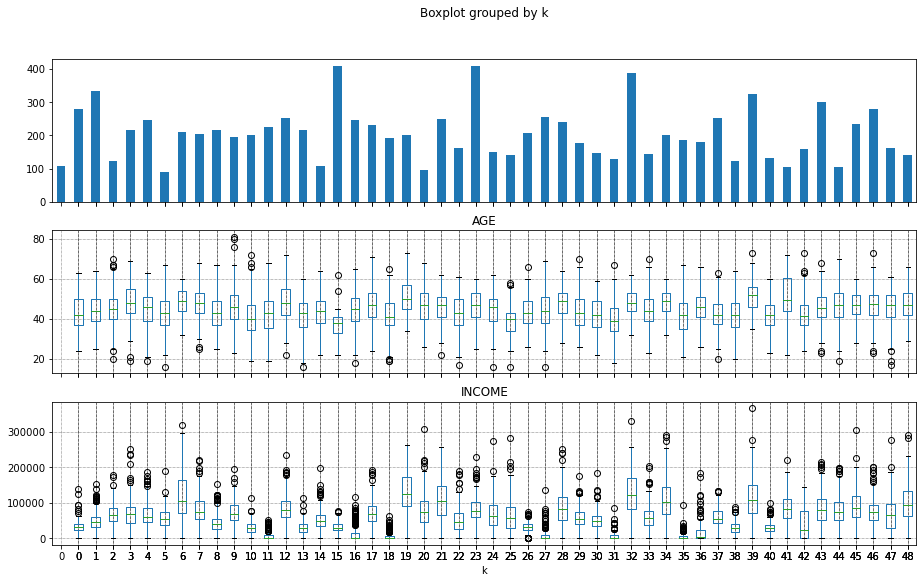

In [22]:
fig,axs = plt.subplots(3,1,figsize=(15,9),sharex=True)
Xy_original['k'] = results[50]['k'].labels_

Xy_original['k'].value_counts().sort_index().plot.bar(ax=axs[0])
Xy_original.boxplot(by='k',column='AGE',ax=axs[1])
Xy_original.boxplot(by='k',column='INCOME',ax=axs[2])

Xy_original.groupby('k').agg(["mean", "median", "var"])[:2]

In [23]:
# drop cluster labels
Xy_original.drop(labels=['k'],axis=1,inplace=True)

### 4.2.2 K-medoids 

K-medoids is similar to Kmeans, but uses an actual data point "medoid" to form clusters rather than the mean value "centroid" location of data wihtin a cluster. K-medoids also takes [different distance metrics to Kmeans](https://stats.stackexchange.com/a/94178/100439), inlcuding Manhattan and Minkowski suited to mixed dataype datasets such as ours. Whilst this makes K-medoids more robust to outliers and feature scale, this is at the expense of added computation and hence is poor perfoming on large datasets and where $k$ is high. 

K-medoids has several implmentations in Python. PAM (partition-around-medoids) is common and implmented in both [pyclustering](https://pypi.org/project/pyclustering/) and [scikit-learn-extra](https://scikit-learn-extra.readthedocs.io/en/latest/install.html). See [here](https://github.com/annoviko/pyclustering/issues/503) and [Schubert, 2018](https://link.springer.com/chapter/10.1007/978-3-030-32047-8_16) for overview of the algorithm implement in pyclustering. Some more usefull links are given below. 

- [PAM  is a variation of K-medoids](https://stats.stackexchange.com/a/141208/100439)
- [Self defined PAM k-medoids in python](https://towardsdatascience.com/k-medoids-clustering-on-iris-data-set-1931bf781e05).
- [k-medoids documentation in pyclustering](https://pyclustering.github.io/docs/0.10.1/html/d0/dd3/classpyclustering_1_1cluster_1_1kmedoids_1_1kmedoids.html)

In [24]:
from pyclustering.cluster.kmedoids import kmedoids
from scipy.spatial.distance import pdist,squareform

K-medoids can be caluclated using many distance metrics. Here the Manhattan or "cityblock" distance is used as this provides a suitable measure where there are both categorical and numerical features. Manhattan distances are computed on the transformed and scaled data set as ```scipy.pdist``` does not perform feature transformation itself.

In [25]:
mhv = pdist(Xy_scaled, 'cityblock',)
mh = squareform(mhv,force='tomatrix')
print(f"Data shape: {Xy_original.shape}\nMatrix shape: {mh.shape}")
pd.DataFrame(mh[:3,:3])

Data shape: (10302, 23)
Matrix shape: (10302, 10302)


,0,1,2
0,0.000000,5.960622,5.921582
1,5.960622,0.000000,6.382310
2,5.921582,6.382310,0.000000


Note, in contrast to scikit, pyclustering return clusters in an $n$ length list of lists, where $n=k$ and $list$[$n$][$i$] is the index postion from the input distance matrix. These are converted to flat array format.

CPU times: user 1min 7s, sys: 1.7 s, total: 1min 8s
Wall time: 1min 8s
CPU times: user 1min 45s, sys: 3.04 s, total: 1min 48s
Wall time: 1min 48s


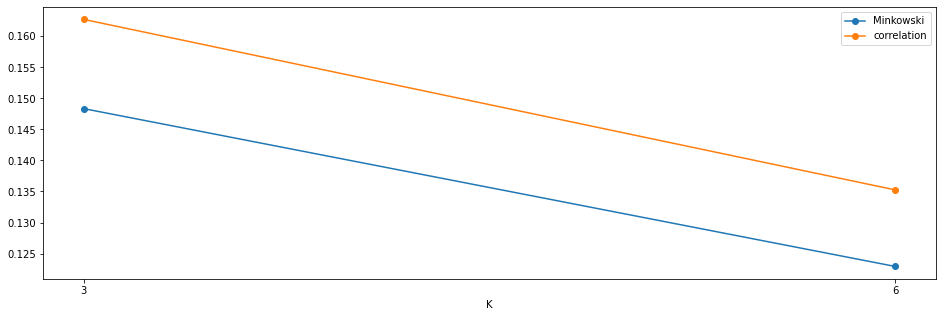

In [26]:
# find k clusters
results_kmedoids = dict()

k_cand = [3,6]

for k in k_cand:
    # initiate k random medoids - sets k clusters
    initial_medoids = np.random.randint(0,1000,size=k)
    kmedoids_instance = kmedoids(mh,
                                 initial_medoids,
                                 data_type='distance_matrix')    

    # run cluster analysis and obtain results
    %time kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    medoids = kmedoids_instance.get_medoids()

    # convert cluster output
    cluster_array = pd.DataFrame([(x,e) for e,i in enumerate(clusters) for x in i if len(i)>1]).sort_values(by=0)[1].values
    
    # score
    score1 = silhouette_score(mh, cluster_array, metric='precomputed')
    score2 = silhouette_score(Xy_scaled, cluster_array,metric='correlation')
    
    # store
    results_kmedoids[k] = {'k':cluster_array,'s1':score1,'s2':score2}

fig,axs = plt.subplots(1,1,figsize=(16,5))
axs.plot([i for i in results_kmedoids.keys()],[i['s1'] for i in results_kmedoids.values()],'o-',label='Minkowski')
axs.plot([i for i in results_kmedoids.keys()],[i['s2'] for i in results_kmedoids.values()],'o-',label='correlation')
axs.set_xticks(k_cand)
axs.set_xlabel('K')
axs.legend();

### 4.2.3 CLARANS 
CLARANS stands for Clustering Large Applications based on RANdomized Search.There is a good write up of [CLARANS](https://medium.com/analytics-vidhya/partitional-clustering-using-clarans-method-with-python-example-545dd84e58b4) here. Briefly, CLARANS builds upon the k-medoid and CLARA methods. The key difference in CLARANS is that cluster centers "centroids" or "medoids" are defined through a limited number of rounds of random sampling and of a limited number of neighbourig points. Crucially, the sampling is not limited to just the neighbouring data of a centroid, but may include any point within the entire dataset. Thus avoiding the development of local minima as in CLARA. The CLARANS paper details this and other methods such as k-medoids so is worth a read [Raymond 2002](http://www.cs.ecu.edu/dingq/CSCI6905/readings/CLARANS.pdf). 
 

The [CLARANS](https://pyclustering.github.io/docs/0.10.1/html/d9/d30/namespacepyclustering_1_1cluster_1_1clarans.html) implementation in [pyclustering](https://pyclustering.github.io/) requires list of lists as its input dataset. Thus we convert the transformed and scaled features data from numpy array to a list. The other inputs are as follows:

- Input data that is presented as list of points (objects), each point should be represented by list or tuple.
- number_clusters: amount of clusters that should be allocated.
- numlocal: the number of local minima obtained (amount of iterations for solving the problem).
- maxneighbor: the maximum number of neighbors examined. The higher the value of maxneighbor, the closer is CLARANS to K-Medoids, and the longer is each search of a local minima.

Note that [clarans.py](https://pyclustering.github.io/docs/0.10.1/html/de/d9f/clarans_8py_source.html) uses Euclidean distance metric. There is no functional reason limiting the CLARANS algortihm to use Euclidean distance and below I have made a custom class locally ```cclarans``` using Manhattan distance. 
 

In [27]:
# customised clarans using Manhattan distance
from cclarans import cclarans
from pyclustering.utils import manhattan_distance,euclidean_distance_square

# manhattan_distance([1,1],[1,2]),euclidean_distance_square([1,1],[1,2])
# manhattan_distance(Xy_scaled_list[0],Xy_scaled_list[1])

Xy_scaled_list = Xy_scaled.to_numpy().tolist()
len(Xy_scaled_list)

clarans_instance = cclarans(data=Xy_scaled_list,
                            number_clusters=10,
                            numlocal=1, 
                            maxneighbor=3)
# %time clarans_instance.process()
# clusters = clarans_instance.get_clusters()

```
CPU times: user 18h 52min 28s, sys: 9.66 s, total: 18h 52min 38s
Wall time: 18h 52min 35s
```

**OK!** As for K-medoids something is clearly not right here. Our supposedly efficient CLARANS is grinding through taking 18 hours to compelete 1 iteration of candidate $k$. 

To confirm that this is not an implementation issue, below is a run of CLARANS on synthetic data of equal size. And which takes less than 60 seconds to run.

CPU times: user 38.2 s, sys: 17.6 ms, total: 38.3 s
Wall time: 38.2 s


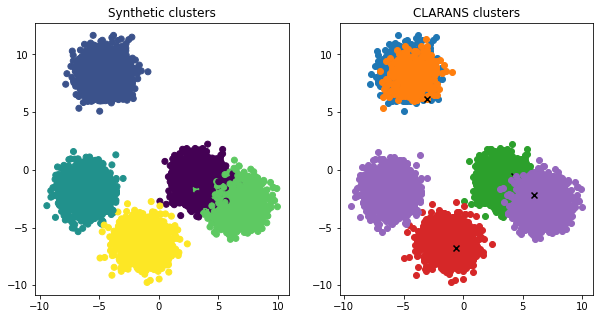

In [28]:
from pyclustering.cluster.clarans import clarans
from sklearn.datasets import make_blobs

# synthetic clusters
I,c = make_blobs(10302,n_features=36,centers=5)

# implement clarans
clarans_instance = clarans(I.tolist(), 5, 2, 4);
%time clarans_instance.process()
clusters = clarans_instance.get_clusters()
medoids = clarans_instance.get_medoids()

fig,axs=plt.subplots(1,2,figsize=(10,5))
axs[0].scatter(I[:,2],I[:,1],c=c)
axs[0].set_title('Synthetic clusters')
axs[1].set_title('CLARANS clusters')
for c_,m in zip(clusters,medoids):
    axs[1].scatter(I[c_,2],I[c_,1])
    axs[1].scatter(I[m,2],I[m,1],marker='x',c='black',label='medoids')

As illustrated above, K-means, K-medoids, and CLARANS, are all suited to flat geometry. That is they are suitable for clusters that form convex hulls. Non-flat geometrical clusters include classical shapes such as spirals, crescents, and concentric rings. 

Given the issues and shortcomings of  these alogrithms, and euclidean distance in high demnsional cases, we will now apply alternative distance metrics and clustering algorithms suited to high dimensional non-flat geometry.  This includes hierachal, [spectral](https://scikit-learn.org/stable/modules/clustering.html#spectral-clustering), or density based approaches such as [HDBSCAN](https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html).

### 4.2.4 Agglomerative Hierarchical Clustering with Gower

[Agglomerative Clustering](https://nlp.stanford.edu/IR-book/html/htmledition/hierarchical-agglomerative-clustering-1.html) is a hierarchical clustering algorithm. In agglomerative clustering, each data point is initially considered as a single cluster, which are then iteratively merged (agglomerated) until all data points form one large cluster. The optimal number of clusters $k$ is found by minimising intra-cluster data point distances and maximising the distance between each unique cluster,

As outlined in section 3.3.1, the Gower distance is a hybrid metric suited to datasets with mixed datatypes. Gower is implemented here in [Gower Python](https://www.thinkdatascience.com/post/2019-12-16-introducing-python-package-gower/). For R users there is [Gower R](https://rdrr.io/cran/gower/api). 

First, lets take a quick look at the ```gower``` package. 

In [29]:
import gower

Gower has two core functions, ```gower_topn``` and ```gower_matrix```. Handily, as per the [source code](https://github.com/wwwjk366/gower/blob/master/gower/gower_dist.py#L61) gower also comes with the functionality to handle feature normalisation and scaling so we could pass either our raw or transformed and scaled data. 

The ```gower_topn``` can be used to find $n$ items related to a single row of data. THs could be usefull for quickly finding similar customers customers or for making movie reccomendations for instance. Below I choose a random row of data and find the tp 5 similar items. 

In [30]:
cat = [True if x in categorical_features else False for x in Xy_original.columns]

n = 5
focus = Xy_original.sample(1)
similar = gower.gower_topn(focus,Xy_original,
                           n=n,cat_features=cat)
focus

,MVR_PTS,YOJ,TIF,CAR_AGE,AGE,TRAVTIME,CLM_AMT,BLUEBOOK,OLDCLAIM,HOME_VAL,...,RED_CAR,GENDER,MSTATUS,URBANICITY,PARENT1,CAR_TYPE,OCCUPATION,EDUCATION,KIDSDRIV,HOMEKIDS
6327,0,7.0,6,18.0,40.0,14,5800.0,26440.0,3699.0,0.0,...,YES,M,NO,URBAN,YES,PTRK,PROFESSIONAL,1,1,1.0


Gower returns the index locations and similarity ```values```. 

In [31]:
print(similar['values'])
Xy_original.iloc[similar['index']]

[0.         0.08845895 0.09403952 0.10647902 0.11503713]


,MVR_PTS,YOJ,TIF,CAR_AGE,AGE,TRAVTIME,CLM_AMT,BLUEBOOK,OLDCLAIM,HOME_VAL,...,RED_CAR,GENDER,MSTATUS,URBANICITY,PARENT1,CAR_TYPE,OCCUPATION,EDUCATION,KIDSDRIV,HOMEKIDS
6327,0,7.0,6,18.0,40.0,14,5800.0,26440.0,3699.0,0.0,...,YES,M,NO,URBAN,YES,PTRK,PROFESSIONAL,1,1,1.0
1210,1,9.0,12,9.0,35.0,27,4621.0,23740.0,0.0,0.0,...,YES,M,NO,URBAN,YES,PTRK,PROFESSIONAL,1,0,1.0
1656,0,14.0,1,14.0,36.0,44,5295.0,31390.0,0.0,0.0,...,YES,M,NO,URBAN,YES,PTRK,MANAGER,1,1,1.0
5487,1,8.0,13,9.0,44.0,43,5125.0,6400.0,0.0,0.0,...,YES,M,NO,URBAN,YES,PKUP,PROFESSIONAL,1,1,1.0
7319,3,11.0,1,8.0,38.0,39,1696.0,30260.0,5255.0,281950.0,...,YES,M,NO,URBAN,YES,PTRK,PROFESSIONAL,1,1,0.0


For agglomerative clustering ```gower_matrix``` is used to calculate a similarity matrix between all records in the dataset. 

In [41]:
# create list of cat_feature indicator
cat = [True if x in categorical_features else False for x in Xy_original.columns]

%time gd = gower.gower_matrix(Xy_original, cat_features=cat)

Calculating Gower dsitances...1-5 minutes
CPU times: user 2min 45s, sys: 530 ms, total: 2min 45s
Wall time: 2min 45s


Calculating the entire matrix may take some time. Once complete Gower returns the full distance matrix.

In [42]:
print(f"Data shape: {Xy_original.shape}\nMatrix shape: {gd.shape}")
pd.DataFrame(gd[:3,:3])

Data shape: (10302, 24)
Matrix shape: (10302, 10302)


,0,1,2
0,0.000000,0.206693,0.177288
1,0.206693,0.000000,0.210374
2,0.177288,0.210374,0.000000


The [scipy.linkage](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage) function is used to perform the hierachal agglomerative clusering. There are a few important considerations here. 

 - ```linkage``` requires a 1D condensed matix as input. We can use ```np.squareform``` to tranform the gower matrix.
 - Some ```linkage``` methods may only be applied to Euclidean distances. *"Methods ‘centroid’, ‘median’, and ‘ward’ are correctly defined only if Euclidean pairwise metric is used."* see the documentation for detail.

Returned is a ($n-1$) by 4 matrix $Z$. At the $i$-th iteration, clusters with indices $Z[i, 0]$ and $Z[i, 1]$ are combined to form a cluster.The distance between clusters $Z[i, 0]$ and $Z[i, 1]$ is given by $Z[i, 2]$. The fourth value $Z[i, 3]$ represents the number of original observations in the newly formed cluster. The format of $Z$ may be a little confusing at first but these stackoverflow answers ([1](https://stackoverflow.com/a/37712929/4538066),[2](https://stackoverflow.com/questions/9838861/scipy-linkage-format)) give a nice explanation.

In [43]:
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

In [44]:
# condensed matrix
gdv = squareform(gd,force='tovector')

# output matrix has format [idx1, idx2, dist, sample_count]
Z = linkage(gdv,method='complete')
Z_df = pd.DataFrame(Z,columns=['id1','id2','dist','n'])
Z_df[:2]

,id1,id2,dist,n
0,6036.0,9801.0,0.000000,2.0
1,2867.0,8191.0,0.000849,2.0


Visualise the hierachal clusters using a [scipy.dendogram](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html#scipy.cluster.hierarchy.dendrogram). Each level and leaf in the dendogram represents a cluster. Clearly displaying the hierachal nature of agglomerative clustering.

Leaves = 64


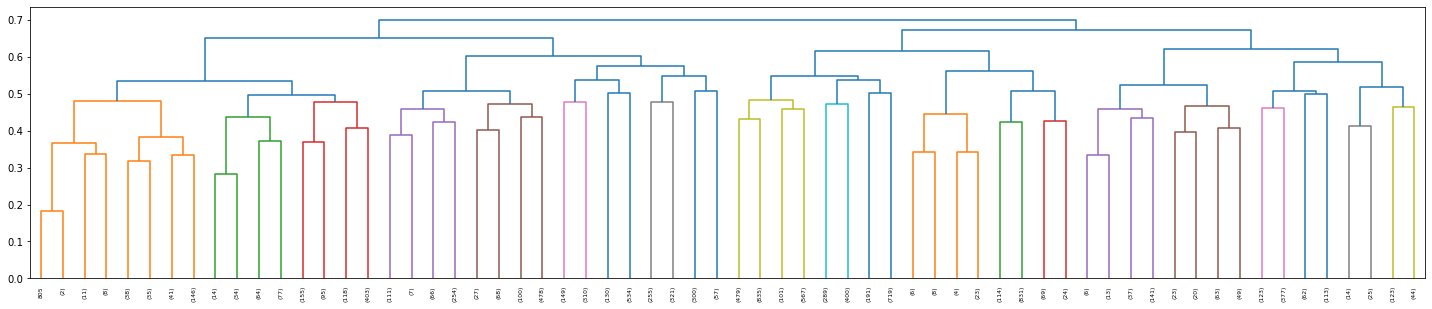

In [45]:
fig,axs = plt.subplots(1,1,figsize=(25,5))
dn = dendrogram(Z, truncate_mode='level',p=5,show_leaf_counts=True,ax=axs);
print(f"Leaves = {len(dn['leaves'])}")

To find the optimal number of clusters we can again apply silhouette scoring. First, 
[scipy.fcluster](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html#scipy.cluster.hierarchy.fcluster) is applied to to form flat clusters from the hierarchical clustering linkage matrix ($Z$).

Silhoette scores are calculated using:
- the precomputed Gower distances in the full gower matrix.
- using correlation

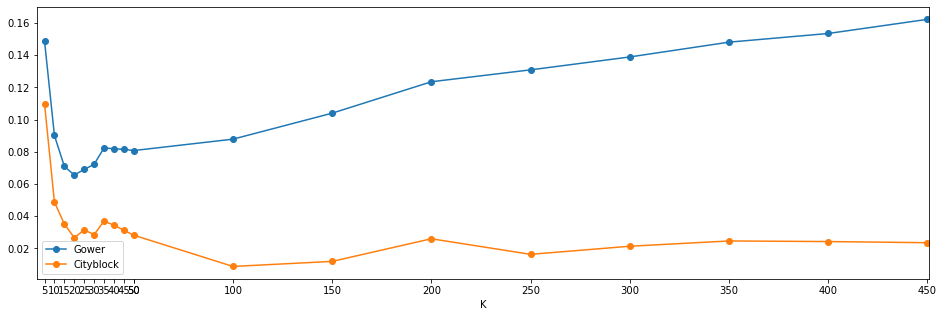

In [50]:
# find k clusters
results = dict()
k_cand = list(np.arange(5,55,5))
k_cand.extend(list(np.arange(50,500,50)))

for k in k_cand:
    cluster_array = fcluster(Z, k, criterion='maxclust')
    score0 = silhouette_score(gd, cluster_array, metric='precomputed')
    score1 = silhouette_score(Xy_scaled, cluster_array,metric='cityblock')
    results[k] = {'k':cluster_array,'s0':score0,'s1':score1}
    
fig,axs = plt.subplots(1,1,figsize=(16,5))
axs.plot([i for i in results.keys()],[i['s0'] for i in results.values()],'o-',label='Gower')
axs.plot([i for i in results.keys()],[i['s1'] for i in results.values()],'o-',label='Cityblock')
axs.set_xlim(1,451)
axs.set_xticks(k_cand)
axs.set_xlabel('K')
axs.legend();

Visualising the silhouette scores and plots shows an interesting result. This new round of clusters appears to have an optimal $k$ of around 5, 10, and 35. As happened previously using Kmeans, silhouette scores are shown to improve once $k$ exceeed 100. However, the correlation scores are flat and this is again indicative of small unique groups.

<AxesSubplot:title={'center':'INCOME'}, xlabel='k'>

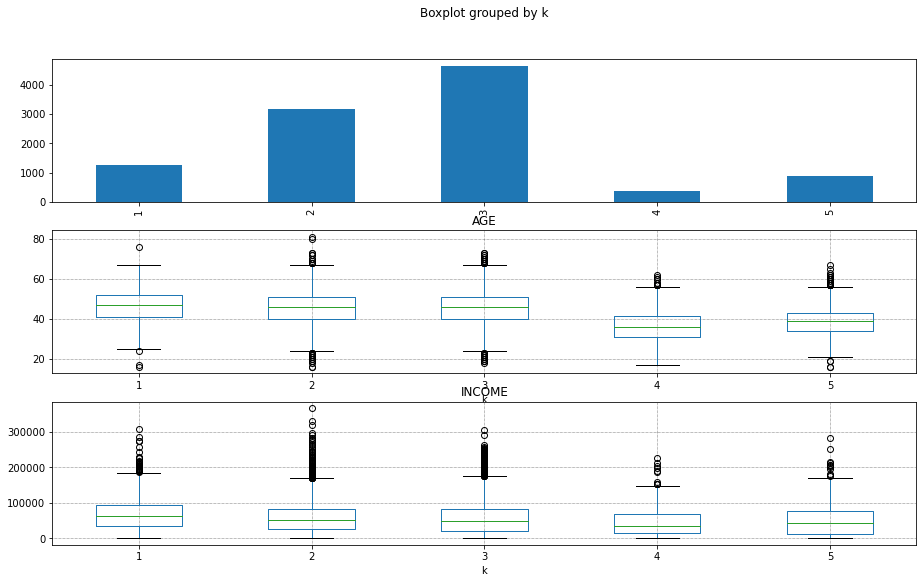

In [49]:
fig,axs = plt.subplots(3,1,figsize=(15,9),sharex=False)
Xy_original['k'] = results[5]['k']

Xy_original['k'].value_counts().sort_index().plot.bar(ax=axs[0])
Xy_original.boxplot(by='k',column='AGE',ax=axs[1])
Xy_original.boxplot(by='k',column='INCOME',ax=axs[2])

## Conclusion

This post has provided an overview of the key considerations for clustering high dimensional data and with varied datatypes. From feature preparation and transformation, distance metrics, to different clustering techniques and alogirithms.

Common issues and challenges include: selecting appropriate distance metrics that suit the nature of the data, avoiding sparsity and dimensional issues; computational efficiency of clustering algorithms, and selecting appropriate clustering algorithms given the apriori unknown geometry of the clustrs. Whilst not exhaustive, this post has shown how to approach these challenges using a variety of techniques. 

Additional methods one might also try include: decomposition, applying principal component and multiple correspondence analysis to the data to reduce dimensionality; in addition to other clustering algorithms such as DBSCAN.

## References

- https://geodacenter.github.io/workbook/7c_clusters_3/lab7c.html#clarans
- https://www.thinkdatascience.com/post/2019-12-16-introducing-python-package-gower/
- https://pypi.org/project/gower/
- https://medium.com/analytics-vidhya/gowers-distance-899f9c4bd553
- https://www.researchgate.net/publication/324073652_Sparse_dynamical_Boltzmann_machine_for_reconstructing_complex_networks_with_binary_dynamics
- https://towardsdatascience.com/clustering-on-mixed-type-data-8bbd0a2569c3
- https://medium.com/@rumman1988/clustering-categorical-and-numerical-datatype-using-gower-distance-ab89b3aa90d9
- https://www2.cs.duke.edu/courses/spring18/compsci216/lectures/07-clustering.pdf
- https://towardsdatascience.com/hierarchical-clustering-on-categorical-data-in-r-a27e578f2995
- https://www.researchgate.net/post/What_is_the_best_way_for_cluster_analysis_when_you_have_mixed_type_of_data_categorical_and_scale
- https://www.google.com/search?client=firefox-b-d&q=python+gower+distance
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html
- https://discuss.analyticsvidhya.com/t/clustering-technique-for-mixed-numeric-and-categorical-variables/6753
- https://stackoverflow.com/questions/24196897/r-distance-matrix-and-clustering-for-mixed-and-large-dataset
- https://www.analyticsvidhya.com/blog/2015/11/easy-methods-deal-categorical-variables-predictive-modeling/
- https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02
- https://rpubs.com/data_feelings/msda_data621_hw4
- https://pypi.org/project/gower/
- https://scikit-learn-extra.readthedocs.io/en/latest/generated/sklearn_extra.cluster.KMedoids.html
- https://towardsdatascience.com/k-medoids-clustering-on-iris-data-set-1931bf781e05
- https://www.rdocumentation.org/packages/cluster/versions/2.1.0/topics/pam
- https://github.com/annoviko/pyclustering/issues/499
- https://stats.stackexchange.com/questions/2717/clustering-with-a-distance-matrix
- https://www.kaggle.com/fabiendaniel/customer-segmentation
- https://dkopczyk.quantee.co.uk/claim-prediction/ (http://web.archive.org/web/20190429040211/https://dkopczyk.quantee.co.uk/claim-prediction/)
- https://www.casact.org/pubs/dpp/dpp08/08dpp170.pdf
- https://medium.com/analytics-vidhya/partitional-clustering-using-clarans-method-with-python-example-545dd84e58b4
- https://www.uio.no/studier/emner/matnat/math/nedlagte-emner/STK2510/v08/undervisningsmateriale/ch8b.pdf
- https://github.com/annoviko/pyclustering/issues/499
- https://stackoverflow.com/questions/3081066/what-techniques-exists-in-r-to-visualize-a-distance-matrix
- https://towardsdatascience.com/the-5-clustering-algorithms-data-scientists-need-to-know-a36d136ef68
- https://datascience.stackexchange.com/questions/22/k-means-clustering-for-mixed-numeric-and-categorical-data
- http://www.cs.ust.hk/~qyang/Teaching/537/Papers/huang98extensions.pdf
- https://www.researchgate.net/post/What_is_the_best_way_for_cluster_analysis_when_you_have_mixed_type_of_data_categorical_and_scale
- https://towardsdatascience.com/hierarchical-clustering-on-categorical-data-in-r-a27e578f2995
- https://gist.github.com/AKST/d27b9006bb0f9670e370
